In [72]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, astropy.units as u, seaborn as sns, astropy, matplotlib as mpl
from matplotlib.lines import Line2D
from astropy.io import fits, ascii as ascii_io
from astropy.coordinates import SkyCoord, Angle
from astroquery.vizier import Vizier
from astroquery.simbad import Simbad

plt.rcParams["font.size"] = "20"

In [116]:
simbad = pd.read_csv("./catalogs/1602003777252A.csv",dtype={'id':str})
old = pd.read_csv("./catalogs/BeSS+Gaia+HMXBs+CSC+XMM.csv")

old[["epsi","AG"]] = old[["epsi","AG"]].apply(pd.to_numeric, errors="coerce")
old["N_H"] = old["AG"].values*2.2e21
old["DR2Name"] = [str(entry).split()[-1][:-1] for entry in old["DR2Name"]]

total = pd.merge(simbad,old,on="Be star")[["Be star","main_type","DR2Name","pmRA","pmDE","rest","epsi","AG","N_H","_2CXO","_4XMM"]]
total.head()

,Be star,main_type,DR2Name,pmRA,pmDE,rest,epsi,AG,N_H,_2CXO,_4XMM
0,BD+62 2346,Be*,431593257757382912,0.970,-3.830,1153.442143,0.186,NaN,NaN,NaN,NaN
1,HD 224905,Be*,429341153012514176,-3.183,-1.434,1465.679924,0.000,0.6860,1.509200e+21,NaN,NaN
2,HD 225095,Em*,420875841188703360,-2.137,-1.519,1254.419479,0.066,0.3683,8.102600e+20,NaN,NaN
3,2 Cet,Star,2414783622022208128,25.559,-9.180,94.255370,1.089,0.3510,7.722000e+20,NaN,NaN
4,10 Cas,Be*,431696822314371456,9.036,0.804,301.387828,0.380,0.4410,9.702000e+20,NaN,NaN


In [106]:
for i in total.index:
    if pd.isna(total.loc[i,"_2CXO"]) and pd.isna(total.loc[i,"_4XMM"]):
        total.loc[i,"Catalog membership"] = "Gaia only"
    elif pd.isna(total.loc[i,"_2CXO"]):
        total.loc[i,"Catalog membership"] = "Gaia+XMM"
    elif pd.isna(total.loc[i,"_4XMM"]):
        total.loc[i,"Catalog membership"] = "Gaia+Chandra"
    else:
        total.loc[i,"Catalog membership"] = "Gaia+Chandra+XMM"

for i in total.index:
    if total.loc[i,"main_type"] in ["Ae*","Be*","*","Em*","Star",'*  ','~  ', "s*b","IR","HII","sg*","SG*","post-AGB*","RB?","Candidate_Be*","Candidate_RGB*","BlueSG*","Radio","Radio(sub-mm)","Cl*"]:
        #total.drop(i, axis=0, inplace=True)
        continue
    elif total.loc[i,"main_type"] in ["Al*","EB*","SB*","** ","**","WU*","bL*","*in**",'EB*WUMa', 'EB*betLyr','EB*Algol',"multiple_object"]:
        total.loc[i,"Class"] = "Binary"
    elif total.loc[i,"main_type"] in ["Pe*","WR*","Pec*"]:
        total.loc[i,"Class"] = "Peculiar/WR"
    elif total.loc[i,"main_type"] in ["Y*?", "Y*O","Candidate_YSO","YSO"]:
        total.loc[i,"Class"] = "YSO"
    elif total.loc[i,"main_type"] in ["*iN","pA*","*inNeb","RfNeb"]:
        total.loc[i,"Class"] = "Nebular"
    elif total.loc[i,"main_type"] in ["Eruptive*","Er*","Orion_V*","Pu*","V* ",'a2*','bC*',"V*","PulsV*bCep","PulsV*","RotV*alf2CVn"]:
        total.loc[i,"Class"] = "Variable"
    elif total.loc[i,"main_type"] in ["HXB","HMXB"]:
        total.loc[i,"Class"] = "HMXB"

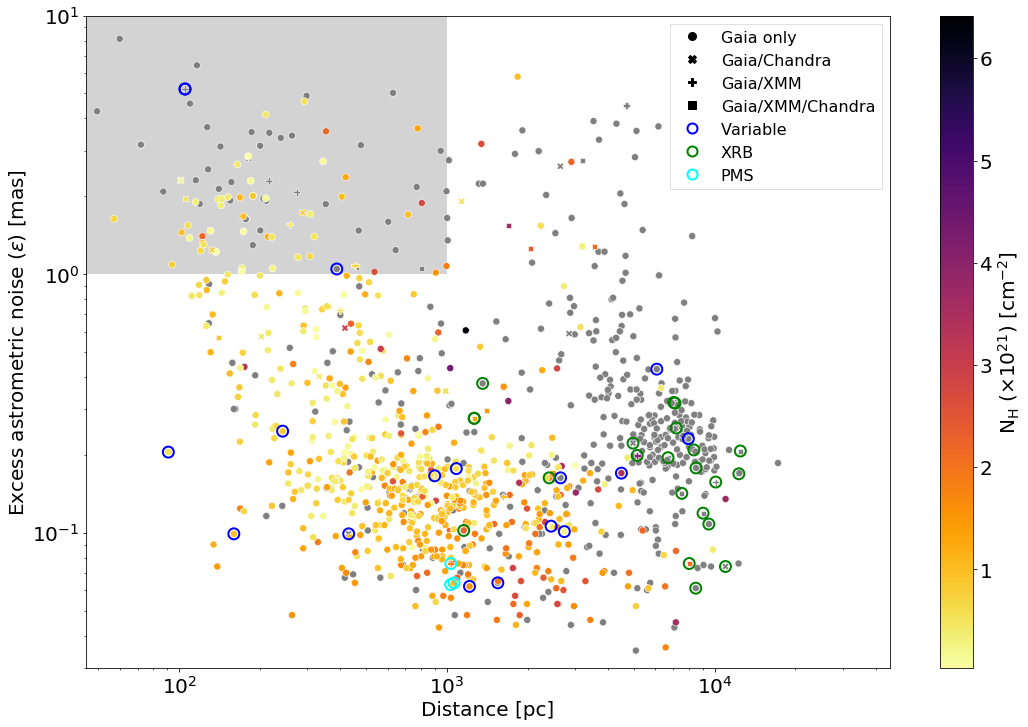

In [114]:
fig, ax = plt.subplots(figsize=(18,12))#, facecolor="lightgrey")
#plt.grid(color="silver",linestyle=":")

ax.add_patch(mpl.patches.Rectangle((0,1),1000,50, edgecolor='none',facecolor='lightgrey',zorder=0))

plot_instance = sns.scatterplot(data=total[total["N_H"].isna()], x="rest", y="epsi", color="grey", style="Catalog membership", s=50, ax=ax, legend=False)

sns.scatterplot(data=total[~total["N_H"].isna()],x="rest",y="epsi",hue="N_H",palette="inferno_r",style="Catalog membership",s=50,ax=ax, legend=False)

ax.scatter(total[total["Class"]=="Variable"]["rest"], total[total["Class"]=="Variable"]["epsi"], s=120, linewidth=2, facecolors='none', edgecolors="b", label="Variable")
#ax.scatter(total[total["Class"]=="Binary"]["rest"], total[total["Class"]=="Binary"]["epsi"], s=120, linewidth=2, facecolors='none', edgecolors="r", label="Binary")
#ax.scatter(total[total["Class"]=="Nebular"]["rest"], total[total["Class"]=="Nebular"]["epsi"], s=120, linewidth=2, facecolors='none', edgecolors="r", label="Nebular")
ax.scatter(total[total["Class"]=="HMXB"]["rest"], total[total["Class"]=="HMXB"]["epsi"], s=120, linewidth=2, facecolors='none', edgecolors="g", label="HMXB")
ax.scatter(total[total["Class"]=="YSO"]["rest"], total[total["Class"]=="YSO"]["epsi"], s=120, linewidth=2, facecolors='none', edgecolors="cyan", label="YSO")
#ax.scatter(total[total["Class"]=="Peculiar/WR"]["rest"], total[total["Class"]=="Peculiar/WR"]["epsi"], s=120, linewidth=2, facecolors='none', edgecolors="yellow", label="Peculiar/WR")

ax.set(ylim=(3e-2,10), xlim=(45,45000), xscale="log", yscale="log", xlabel="Distance [pc]", ylabel="Excess astrometric noise ($\epsilon$) [mas]")

fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=total["N_H"].min()/1e21, vmax=total["N_H"].max()/1e21, clip=False), cmap='inferno_r'),label='N$_\mathrm{H}$ (×$10^{21}$) [cm$^{-2}$]',ax=ax)

legend_elements = [Line2D([0], [0], linestyle="", marker='o', color="k", label='Gaia only', markersize=8),
                   Line2D([0], [0], linestyle="", marker='X', color="k", label='Gaia/Chandra', markersize=8),
                   Line2D([0], [0], linestyle="", marker='P', color="k", label='Gaia/XMM', markersize=8),
                   Line2D([0], [0], linestyle="", marker='s', color="k", label='Gaia/XMM/Chandra', markersize=8),
                   Line2D([0], [0], linestyle="", marker='o', mfc="none", mec='b', label='Variable', markersize=10, mew=2),
                   #Line2D([0], [0], linestyle="", marker='o', mfc="none", mec='r', label='Binary', markersize=10, mew=2),
                   #Line2D([0], [0], linestyle="", marker='o', mfc="none", mec='r', label='Nebular', markersize=10, mew=2),
                   Line2D([0], [0], linestyle="", marker='o', mfc="none", mec='g', label='XRB', markersize=10, mew=2),
                   Line2D([0], [0], linestyle="", marker='o', mfc="none", mec='cyan', label='PMS', markersize=10, mew=2),
                   #Line2D([0], [0], linestyle="", marker='o', mfc="none", mec='yellow', label='Peculiar', markersize=10, mew=2),
                   #mpl.patches.Patch(facecolor='lightgrey', edgecolor='none', label='$\epsilon>1,d>1$ kpc')
                   ]

legend = ax.legend(handles=legend_elements, loc='upper right', fancybox=False, framealpha=0.6, fontsize=16)#, bbox_to_anchor=(1.15,1))


fig.savefig("./plots/gaia_epsi_vs_rest.png",bbox_inches="tight",dpi=300)#,facecolor="lightgrey")

In [119]:
total["pm"] = np.sqrt(total["pmRA"]**2 + total["pmDE"]**2)*2.77777778e-07 # magnitude of the proper motion vector in deg/yr
total["Vel"] = total["rest"]*np.tan(total["pm"]) # pc/yr